# Paradoks Siłowni - Regresja Liniowa z Haczykiem

Witaj w zadaniu, w którym Twoim celem jest przewidzenie przyrostu siły (Gain) na podstawie czasu spędzonego na treningu.

Na pierwszy rzut oka sprawa wydaje się prosta: **im więcej trenujesz, tym silniejszy się stajesz**, prawda?
Cóż, dane z naszej siłowni mogą sugerować coś zupełnie innego...

Twoim zadaniem jest:
1. Zrozumieć dane poprzez gotowe wizualizacje.
2. Zauważyć, dlaczego prosta regresja liniowa zawodzi.
3. Przetworzyć dane (Feature Engineering) tak, aby model nauczył się poprawnych zależności.
4. Wysłać plik z predykcjami dla zbioru testowego.

## Opis Danych

Dostajesz dwa pliki: `train.npz` oraz `test.npz`.

Każdy z nich zawiera macierz `X` o dwóch kolumnach:
1. **Kolumna 0 (`Hours`)**: Średnia liczba godzin treningu w tygodniu.
2. **Kolumna 1 (`Is_Pro`)**: Status osoby ćwiczącej (0 = Początkujący, 1 = Zawodowiec).

Plik treningowy zawiera dodatkowo wektor `y`:
* **`Gain`**: Przyrost siły w kg (np. w wyciskaniu) w skali roku.

### Cel
Musisz przewidzieć `Gain` dla osób ze zbioru testowego.


## Kryterium oceny – błąd MSE

Jakość przewidywań mierzymy za pomocą błędu średniokwadratowego (MSE – *Mean Squared Error*).

Jeśli mamy prawdziwe wartości \\( y_1, \dots, y_n \\) oraz przewidywania modelu
\\( \hat{y}_1, \dots, \hat{y}_n \\), to:

\\[
\mathrm{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2.
\\]

Im **mniejsza** wartość MSE, tym lepszy model.

### Punktacja

Punktacja zależy od MSE na zbiorze testowym:

* jeśli \\( \mathrm{MSE} > 15 \\) – dostajesz **0 punktów**,
* jeśli \\( \mathrm{MSE} < 10 \\) – dostajesz **1 punkt**,
* jeśli \\( 10 \le \mathrm{MSE} \le 15 \\) – punkty są skalowane **liniowo**.

Zatem możemy zapisać liczbę punktów jako:

$$
\text{punkty}(\mathrm{MSE}) =
\begin{cases}
1, & \text{gdy } \mathrm{MSE} \le 10,\\
0, & \text{gdy } \mathrm{MSE} \ge 15,\\
\dfrac{15 - \mathrm{MSE}}{5}, & \text{w przeciwnym razie.}
\end{cases}
$$


## 1. Wczytanie i wizualizacja danych

Zacznijmy od wczytania danych i zobaczenia, z czym mamy do czynienia. 
Uruchom poniższe komórki.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Wczytanie danych
data_train = np.load("train.npz")
X_train_raw = data_train['X']  # Kolumny: [Godziny, Czy_Pro]
y_train = data_train['y']

data_test = np.load("test.npz")
X_test_raw = data_test['X']

print("Kształt danych treningowych X:", X_train_raw.shape)
print("Przykładowy wiersz (Godziny, Czy_Pro):", X_train_raw[0])

Kształt danych treningowych X: (700, 2)
Przykładowy wiersz (Godziny, Czy_Pro): [12.29190339  1.        ]


In [2]:
import pandas as pd

df = pd.DataFrame(X_train_raw)
df = df.rename(columns={0: 'Hours', 1: 'Is_Pro'})
df['Gain'] = y_train
df.head(10)

,Hours,Is_Pro,Gain
0,12.291903,1.0,12.000105
1,15.119192,1.0,13.735741
2,8.774481,1.0,14.114628
3,5.291046,0.0,47.497063
4,2.178596,0.0,37.925165
5,14.257690,1.0,12.475787
6,12.949718,1.0,14.486755
7,4.363662,0.0,49.559639
8,4.523329,0.0,47.329491
9,5.834237,0.0,53.300693


### Wizualizacja: Paradoks Siłowni

Poniższy kod narysuje wykres zależności przyrostu siły od czasu treningu. 
Kolorem zaznaczymy, czy ktoś jest początkującym (niebieski) czy zawodowcem (pomarańczowy).

Dodatkowo, **czerwona linia** pokazuje, co by się stało, gdybyśmy użyli regresji liniowej ignorując poziom zaawansowania.

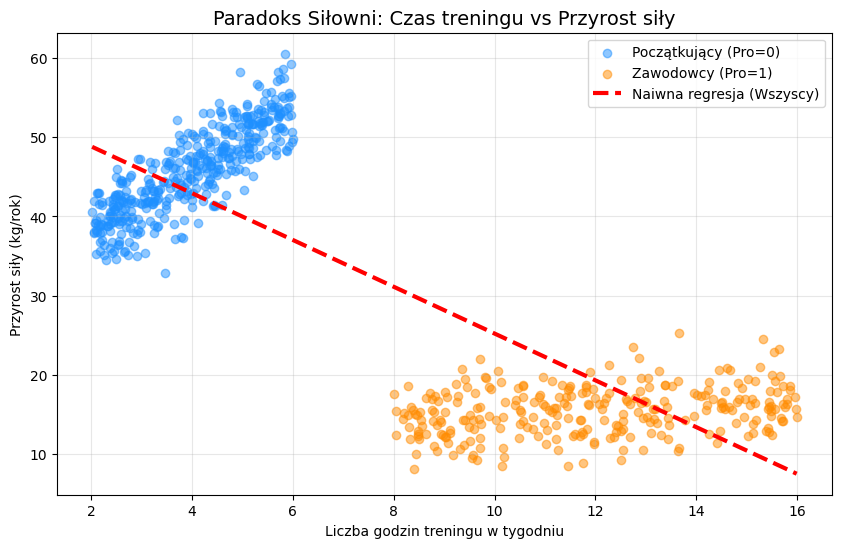

In [3]:
# === KOD DO WIZUALIZACJI (NIE MODYFIKUJ) ===

plt.figure(figsize=(10, 6))

# Rozdzielamy dane do wykresu
hours = X_train_raw[:, 0]
is_pro = X_train_raw[:, 1]

# Rysujemy punkty - Początkujący
plt.scatter(hours[is_pro == 0], y_train[is_pro == 0], 
            alpha=0.5, label='Początkujący (Pro=0)', c='dodgerblue')

# Rysujemy punkty - Zawodowcy
plt.scatter(hours[is_pro == 1], y_train[is_pro == 1], 
            alpha=0.5, label='Zawodowcy (Pro=1)', c='darkorange')

# Naiwna regresja (tylko na podstawie godzin, ignorując grupę)
naive_model = LinearRegression()
naive_model.fit(hours.reshape(-1, 1), y_train)
x_range = np.linspace(hours.min(), hours.max(), 100).reshape(-1, 1)
y_naive = naive_model.predict(x_range)

plt.plot(x_range, y_naive, color='red', linewidth=3, linestyle='--', label='Naiwna regresja (Wszyscy)')

plt.title("Paradoks Siłowni: Czas treningu vs Przyrost siły", fontsize=14)
plt.xlabel("Liczba godzin treningu w tygodniu")
plt.ylabel("Przyrost siły (kg/rok)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Co widzisz na wykresie?

1. **Czerwona linia leci w dół!** Sugeruje ona, że im więcej trenujesz, tym gorsze masz wyniki. Czy to ma sens? Oczywiście nie.
2. Spójrz na **niebieską chmurę** (Początkujący): Tutaj trend jest rosnący (więcej godzin = większy przyrost).
3. Spójrz na **pomarańczową chmurę** (Zawodowcy): Tutaj trend też jest rosnący, ale znacznie łagodniejszy (trudniej o postęp).

Problem polega na tym, że zawodowcy trenują bardzo dużo godzin, ale mają (naturalnie) mniejsze przyrosty niż nowicjusze. To "ciągnie" prostą regresji w dół.

Musisz zbudować **JEDEN** model, który zauważy te **DWIE** osobne grupy!

## 2. Inżynieria Cech (Feature Engineering)

Twój model regresji liniowej ma postać: 
$$ y = w_1 \cdot x_1 + w_2 \cdot x_2 + ... + b $$

Jeśli podasz mu po prostu `Godziny`, model wyznaczy jedną linię dla wszystkich (czerwoną).
Jeśli podasz mu `Godziny` i `Czy_Pro`, model będzie mógł przesunąć linię w górę/dół, ale **nadal obie linie będą równoległe** (będą miały ten sam kąt nachylenia).

A my widzimy, że początkujący rosną szybciej (stroma linia), a zawodowcy wolniej (płaska linia).

### Zadanie
Uzupełnij funkcję `prepare_features`, która przerobi nasze dane wejściowe. Zamiast dwóch kolumn, stwórzmy ich więcej, aby model mógł nauczyć się "dwóch osobnych regresji" w jednym równaniu.

In [4]:
def prepare_features(X_raw: np.ndarray):
    """
    Funkcja przetwarza surowe dane wejściowe (n_samples, 2) na nowe cechy.
    X_raw[:, 0] -> Godziny
    X_raw[:, 1] -> Czy_Pro (0 lub 1)
    """
    hours = X_raw[:, 0]
    is_pro = X_raw[:, 1]
    
    # --- TU WPISZ SWÓJ KOD ---
    X_new = X_raw   # Przykładowo zostawiamy dokładnie to samo, co było wcześniej
    
    return X_new

# Przetwarzamy dane treningowe i testowe Twoją funkcją
X_train_processed = prepare_features(X_train_raw)
X_test_processed = prepare_features(X_test_raw)

print("Nowy kształt danych treningowych:", X_train_processed.shape)

Nowy kształt danych treningowych: (700, 2)


In [5]:
import pandas as pd

df = pd.DataFrame(X_train_processed)
df['Gain'] = y_train
df.head(10)

,0,1,Gain
0,12.291903,1.0,12.000105
1,15.119192,1.0,13.735741
2,8.774481,1.0,14.114628
3,5.291046,0.0,47.497063
4,2.178596,0.0,37.925165
5,14.257690,1.0,12.475787
6,12.949718,1.0,14.486755
7,4.363662,0.0,49.559639
8,4.523329,0.0,47.329491
9,5.834237,0.0,53.300693


## 3. Trenowanie Modelu

Teraz wytrenujmy model na Twoich nowych cechach.

In [6]:
# Tworzymy model
model = LinearRegression()

# Trenujemy na PRZETWORZONYCH danych
model.fit(X_train_processed, y_train)

# Sprawdźmy błąd na zbiorze treningowym
y_pred_train = model.predict(X_train_processed)
mse_train = np.mean((y_train - y_pred_train) ** 2)

print(f"Twój błąd MSE na treningu: {mse_train:.2f}")
print("Jeśli zrobiłeś to dobrze, błąd powinien być w okolicy 9.0 (to szum danych).")
print("Jeśli błąd jest duży (>50), to znaczy, że model nadal widzi 'czerwoną linię'.")

# Podejrzyjmy nauczone wagi
print("\nNauczone współczynniki:", model.coef_)
print("Wyraz wolny (intercept):", model.intercept_)

Twój błąd MSE na treningu: 16.56
Jeśli zrobiłeś to dobrze, błąd powinien być w okolicy 9.0 (to szum danych).
Jeśli błąd jest duży (>50), to znaczy, że model nadal widzi 'czerwoną linię'.

Nauczone współczynniki: [  1.31868086 -40.75872717]
Wyraz wolny (intercept): 40.51599998968611


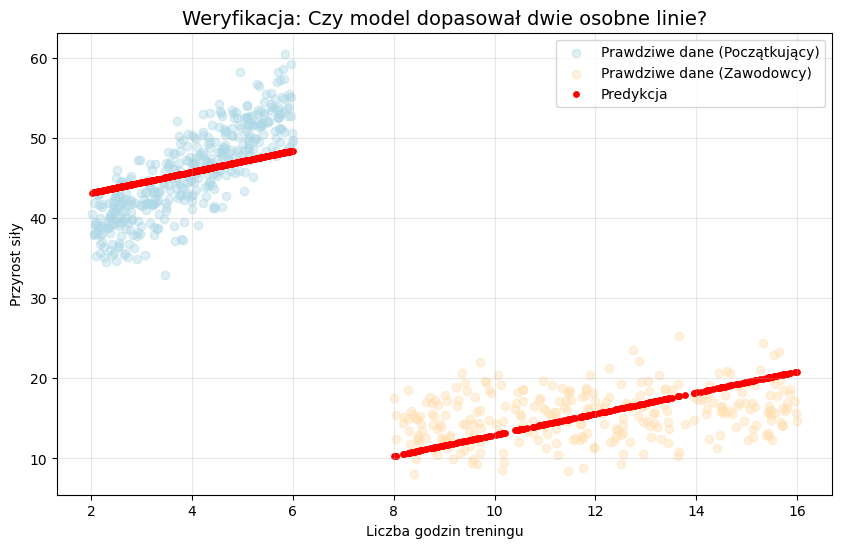

In [7]:
# === WIZUALIZACJA WYNIKÓW MODELU ===

plt.figure(figsize=(10, 6))

# Pobieramy oryginalne godziny i status pro do osi X i kolorowania
hours = X_train_raw[:, 0]
is_pro = X_train_raw[:, 1]

# 1. Rysujemy PRAWDZIWE dane (nieco wyblakłe, jako tło)
plt.scatter(hours[is_pro == 0], y_train[is_pro == 0], 
            color='lightblue', alpha=0.4, label='Prawdziwe dane (Początkujący)')
plt.scatter(hours[is_pro == 1], y_train[is_pro == 1], 
            color='navajowhite', alpha=0.4, label='Prawdziwe dane (Zawodowcy)')

# 2. Rysujemy PREDYKCJE modelu (ciemniejsze, wyraźne punkty)
# To pokazuje, jak model "widzi" świat po inżynierii cech
plt.scatter(hours, y_pred_train, 
            color='red', s=15, label='Predykcja')

plt.title("Weryfikacja: Czy model dopasował dwie osobne linie?", fontsize=14)
plt.xlabel("Liczba godzin treningu")
plt.ylabel("Przyrost siły")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Zapisanie Wyników

Wygeneruj predykcje dla zbioru testowego i zapisz je.

In [8]:
y_test_pred = model.predict(X_test_processed)

np.savez("solution.npz", y=y_test_pred)
print("Zapisano plik solution.npz! Jesteś gotowy do wysłania.")

Zapisano plik solution.npz! Jesteś gotowy do wysłania.
